In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq /content/drive/MyDrive/termwork/visualization.zip

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/PATH-DT-MSU.WSS1_psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_01.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_02.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_03.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_04.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_05.psi.zip

In [ ]:
from pathlib import Path

from PIL import Image
!pip install visualization/psimage-0.1.0-py3-none-any.whl

from psimage.image import PSImage
from skimage import io
import matplotlib.pyplot as plt
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode as IM

from tqdm import tqdm

import json

Processing ./visualization/psimage-0.1.0-py3-none-any.whl
psimage tile cache size was set up to 300 tiles


# Метод

In [ ]:
import sys
from pathlib import Path
import numpy as np
import math
import matplotlib.pyplot as plt

def resize(img, target_shape=(512, 512)):
    assert target_shape[0] == target_shape[1]


    img = transforms.Resize(target_shape[0])(img)
    resize_transform = transforms.Compose([
        transforms.CenterCrop(target_shape[0]),
    ])

    return resize_transform(img)

class Classifier:
    def __init__(self, path):
        self.path = path
        psimage = PSImage(self.path)
        self.layers = psimage.layout.layers
        self.tile_s = psimage.layout.tile_s
        numbers = list(range(len(self.layers)))

        layers = [1 << i for i in numbers]
        self.layerTOnumber = dict(zip(numbers, self.layers))

        self.pyramid = []
        for layer in self.layers:
            height_pixels, width_pixels = psimage.layer_size(layer)
            height, width = math.ceil(height_pixels / self.tile_s), math.ceil(width_pixels / self.tile_s)
            tiles = np.full((height, width), -1)
            self.pyramid.append(tiles)

        self.shapes = []
        for tiles in self.pyramid:
            self.shapes.append(tiles.shape)

        self.zero_padding()

        psimage.close()

    def make_classification(self, classifier):
        classifier.eval()
        with torch.no_grad():
            t_dict = {
                "forward_input": transforms.Compose([
                    transforms.PILToTensor(),
                    transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
                ]),
                "backward_input": transforms.Compose([
                    transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                                std=[1./0.229, 1./0.224, 1./0.225]),
                    transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                std=[1.0, 1.0, 1.0]),
                    transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
                ]),
            }

            LAYER = 0
            psimage = PSImage(self.path)
            #tiles = self.pyramid[LAYER]
            for y in tqdm(range(self.shapes[LAYER][0]), total=self.shapes[LAYER][0]):
                for x in range(self.shapes[LAYER][1]):
                    image = psimage.get_tile(self.layerTOnumber[0], y, x)
                    new_im = resize(Image.fromarray(image), (512, 512))
                    trans_im = t_dict['forward_input'](new_im)
                    pred = classifier(torch.unsqueeze(trans_im, 0))

                    self.pyramid[LAYER][y, x] = pred.argmax().cpu().detach().numpy()


            psimage.close()



    def zero_padding(self):
        for layer in range(0, len(self.layers) - 1):
            tiles = self.pyramid[layer]
            height, width = self.shapes[layer]
            new_tiles = np.zeros((height if height % 2 == 0 else height + 1, width if width % 2 == 0 else width + 1))
            new_tiles[:height, :width] = tiles
            self.pyramid[layer] = new_tiles.astype(int)

    def propagate_prediction(self):
        window_size = 2
        for layer in range(1, len(self.layers)): #начало с перврго слоя
            for y in range(self.shapes[layer][0]):
                for x in range(self.shapes[layer][1]):
                    y0, x0 = y * window_size, x * window_size
                    y0, x1 = y * window_size, x * window_size + 1
                    y1, x0 = y * window_size + 1, x * window_size
                    y1, x1 = y * window_size + 1, x * window_size + 1
                    self.pyramid[layer][y][x] = self.pyramid[layer - 1][y0][x0] | self.pyramid[layer - 1][y0][x1] | self.pyramid[layer - 1][y1][x0] | self.pyramid[layer - 1][y1][x1]

        #for layer in range(0, len(self.layers)):
        #    for y in range(self.shapes[layer][0]):
        #        for x in range(self.shapes[layer][1]):
        #            print(self.pyramid[layer][y, x], ' ', end="", sep='')
        #        print()


    def get_prediction(self, z, y, x):
        return self.pyramid[z][y, x]

    def get_pair(self, z, y, x):
        pred = self.get_prediction(z, y, x)

        psimage = PSImage(self.path)
        img = psimage.get_tile(self.layerTOnumber[z], y, x)
        psimage.close()
        return np.array(img), pred

    def make_mask(self, layer, shape):
        psim = PSImage(self.path)

        mask = np.zeros(shape)

        size_y, size_x = shape[0] // self.shapes[layer][0], shape[1] // self.shapes[layer][1]

        scip_y = 0
        size_y, size_x, last_y, last_x = self.get_size(shape, self.shapes[layer])

        for y in range(self.shapes[layer][0]):
            scip_x = 0
            scip = 0
            for x in range(self.shapes[layer][1]):
                final_size_y = size_y if y < self.shapes[layer][0] - 1 else last_y
                final_size_x = size_x if x < self.shapes[layer][1] - 1 else last_x
                mask_part = np.full((final_size_y,final_size_x,3), self.pyramid[layer][y][x])

                mask[scip_y:scip_y + mask_part.shape[0], scip_x:scip_x + mask_part.shape[1]] = self.pyramid[layer][y][x]
                scip_x += mask_part.shape[1]
                scip = mask_part.shape[0]
            scip_y += scip

        psim.close()
        return mask

    def get_size(self, shape, layer_shape):
        pows = [1 << i for i in range(15) if ((1 << i) < shape[0]) and ((1 << i) < shape[1])]
        pow1 = min(pows, key=lambda x:abs(x-shape[0]/(layer_shape[0]-1))) if layer_shape[0] != 1 else shape[0]
        pow2 = min(pows, key=lambda x:abs(x-shape[1]/(layer_shape[1]-1))) if layer_shape[1] != 1 else shape[1]
        return pow1, pow2, shape[0] - (layer_shape[0] - 1) * pow1, shape[1] - (layer_shape[1] - 1) * pow2

    def make_json(self):

        psimage = PSImage(self.path)
        codes = []
        for layer, tiles in psimage.layout.tiles_per_layer().items():
        #print(psimage.get_tile(self.layerTOnumber[0], 0, 1))
            #print(f"Layer {layer}, tiles: {len(tiles)} ({tiles[-3:]}...)")
            for tile in tiles:
                z, y, x = map(int, tile.code.split('_'))
                if self.pyramid[int(np.log2(z))][y, x] == 0:
                    codes.append(tile.code)

        with open('_'.join(str(self.path).split('/')) + ".json", "w") as file:
            json.dump(codes, file)

            #        pass
            #print(f"Layer {layer}, tiles: {len(tiles)} ({tiles[:3]}...)")

        #for layer in range(0, len(self.layers)):
        #    for y in tqdm(range(self.shapes[layer][0]), total=self.shapes[layer][0]):
        #        for x in range(self.shapes[layer][1]):
        #            if self.get_prediction(layer, y, x):



def save_mask(mask, name):
    im1 = Image.fromarray((mask * 255).astype(np.uint8))

    im2 = Image.open("data/out/export.jpg")
    blended = Image.blend(im1, im2, alpha=0.5)
    blended.save(name)

def visualize(image, label):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title(f"CLASS: {label}")
    plt.show()


In [ ]:
p = Path("test_04.psi")

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', weights=None)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load("visualization/best_model.pth"))
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)

Cl = Classifier(Path(p))
Cl.make_classification(model)
Cl.propagate_prediction()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 164/164 [09:52<00:00,  3.61s/it]


In [ ]:
Cl.make_json()

In [ ]:
from google.colab import files
files.download("/content/masks_wss2_5.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Визуализация

In [ ]:
t_dict = {
    "forward_input": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    ]),
    "backward_input": transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                    std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                    std=[1.0, 1.0, 1.0]),
        transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
    ]),
}

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', weights=None)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load("visualization/best_model.pth"))
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)

model.eval()
with torch.no_grad():
    new_im = resize(Image.open('/content/1_16_31.jpg'), (512, 512))
    trans_im = t_dict['forward_input'](new_im)
    pred = model(torch.unsqueeze(trans_im, 0))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
psimage = PSImage(Path("test_02.psi"))
im = Image.fromarray(psimage.get_tile(1, 6, 5))
im.save("im.jpg")

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
def resize(img, target_shape=(512, 512)):
    assert target_shape[0] == target_shape[1]


    img = transforms.Resize(target_shape[0])(img)
    resize_transform = transforms.Compose([
        transforms.CenterCrop(target_shape[0]),
    ])

    return resize_transform(img)

def make_mask(psim, shape, scale, classifier=None):
    classifier.eval()
    with torch.no_grad():
        t_dict = {
            "forward_input": transforms.Compose([
                transforms.PILToTensor(),
                transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
            ]),
            "backward_input": transforms.Compose([
                transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                            std=[1./0.229, 1./0.224, 1./0.225]),
                transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                            std=[1.0, 1.0, 1.0]),
                transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
            ]),
        }

        layers = psim.layout.layers
        tile_s = psim.layout.tile_s
        numbers = list(range(len(layers)))
        layers = [1 << i for i in numbers]
        layerTOnumber = dict(zip(numbers, layers))

        layer = layers[0]
        height_pixels, width_pixels = psim.layer_size(layer)
        height, width = math.ceil(height_pixels / tile_s), math.ceil(width_pixels / tile_s)
        print(height, width)

        mask = np.zeros(shape)
        scip_y = 0
        for y in tqdm(range(height), total=height):
            scip_x = 0
            scip = 0
            for x in range(width):
                image = psim.get_tile(layerTOnumber[0], y, x)
                new_im = resize(Image.fromarray(image), (512, 512))
                trans_im = t_dict['forward_input'](new_im)
                pred = classifier(torch.unsqueeze(trans_im, 0))
                mask_part = np.full((int(image.shape[0] * scale),int(image.shape[1] * scale),3), pred.argmax().cpu().detach().numpy())
                mask[scip_y:scip_y + mask_part.shape[0], scip_x:scip_x + mask_part.shape[1]] = mask_part
                scip_x += mask_part.shape[1]
                scip = mask_part.shape[0]
            scip_y += scip
    return mask



In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', weights=None)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load("visualization/best_model.pth"))
model.to(DEVICE)
p = Path("visualization/test_01.psi")
with PSImage(p) as psim:
    psim.export_simple(Path("data/out/export.jpg"), scale=0.125)
    image = io.imread("data/out/export.jpg")
    print(image.shape)
    #mask = make_mask(psim, image.shape, 0.125, model)
    #plt.imshow(image)
    #plt.imshow(mask, alpha=0.5)
    #plt.show()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


(3594, 4731, 3)


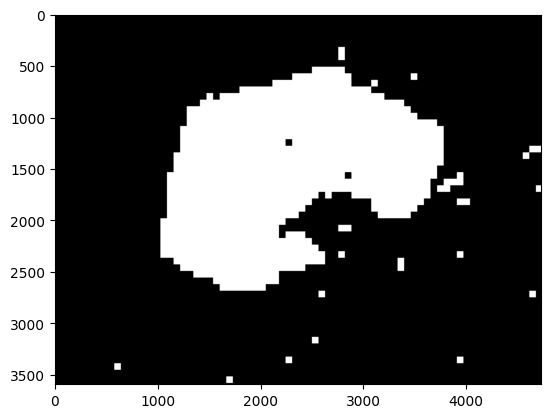

In [ ]:
plt.imshow(mask)

In [ ]:
def make_mask(psim, size, stride, classifier):
    classifier.eval()
    with torch.no_grad():
        t_dict = {
            "forward_input": transforms.Compose([
                transforms.PILToTensor(),
                transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
            ]),
            "backward_input": transforms.Compose([
                transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                            std=[1./0.229, 1./0.224, 1./0.225]),
                transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                            std=[1.0, 1.0, 1.0]),
                transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
            ]),
        }
        layers = psim.layout.layers
        #tile_s = psim.layout.tile_s
        numbers = list(range(len(layers)))
        layers = [1 << i for i in numbers]
        layerTOnumber = dict(zip(numbers, layers))

        layer = layers[0]
        height_pixels, width_pixels = psim.layer_size(layer)
        height, width = math.ceil(height_pixels / stride), math.ceil(width_pixels / stride)


        window_size = (size // stride)

        xv, yv = np.meshgrid(np.arange(width), np.arange(height))
        #print(height, width)
        #print(xv.shape, yv.shape)
        coords = np.zeros((3, height, width), dtype=np.uint8)
        #print(coords.shape)
        mask = np.full((window_size ** 2, height, width), np.nan)
        coords[1, ...] = yv
        coords[2, ...] = xv
        print(coords)
        stride_y = 0
        stride_x = 0
        next = 0
        print(mask.shape)
        for patch in tqdm(psim.patch_gen_dense(size, stride=stride)):

            if patch.pos_y / stride > stride_y:
                stride_x = 0
                stride_y += 1
            #print(stride_x, stride_y)
            data = patch.data
            patch_height, patch_width, C = data.shape
            size_y, size_x = math.ceil(patch_height / stride), math.ceil(patch_width / stride)
            slic = np.s_[:, stride_y:stride_y + size_y,stride_x:stride_x + size_x]
            cor = coords[slic]
            ravel_cor = np.zeros((3, cor[0].size), dtype=np.uint8)
            ravel_cor[0] = cor[0].ravel()
            ravel_cor[1] = cor[1].ravel()
            ravel_cor[2] = cor[2].ravel()

            stride_x += 1
            #print(mask[ravel_cor[0], ravel_cor[1], ravel_cor[2]])
            new_im = resize(Image.fromarray(data), (512, 512))
            trans_im = t_dict['forward_input'](new_im)
            pred = classifier(torch.unsqueeze(trans_im, 0))
            mask[ravel_cor[0], ravel_cor[1], ravel_cor[2]] = pred.argmax().cpu().detach().numpy()
            #print(mask[ravel_cor[0], ravel_cor[1], ravel_cor[2]])
            cor[0] += 1
            #print(ravel_cor)
            #print(cor)
            #print(coords)
            #mask = np.full((math.ceil(patch_height / stride), math.ceil(patch_width / stride)), np.random.choice([0,1]))

            #print(patch.pos_x / stride, patch.pos_y / stride)
            #print(mask)


            #image_height // stride
            #print(patch.data.shape)
            #size1 = window_size
            #window = np.random.choice([0, 1], size=())
        delitel = (~np.isnan(mask)).sum(axis=0)
        print(delitel)
        mask = np.where(np.isnan(mask), 0, mask)
        print(mask)

        return mask.sum(axis=0) / delitel

In [ ]:
def make_heatmap(psim, shape, mask, scale, stride):
    layers = psim.layout.layers
    tile_s = psim.layout.tile_s
    numbers = list(range(len(layers)))
    layers = [1 << i for i in numbers]
    layerTOnumber = dict(zip(numbers, layers))

    heatmap = np.zeros(shape)

    layer = layers[0]
    height_pixels, width_pixels = psim.layer_size(layer)
    height, width = math.ceil(height_pixels / tile_s), math.ceil(width_pixels / tile_s)

    scip_y = 0
    for y in range(mask.shape[0]):
        scip_x = 0
        scip = 0
        for x in range(mask.shape[1]):
            heatmap_part = np.full((int(stride * scale),int(stride * scale),3), mask[y][x])
            heatmap[scip_y:scip_y + heatmap_part.shape[0], scip_x:scip_x + heatmap_part.shape[1]] = mask[y][x]
            scip_x += heatmap_part.shape[1]
            scip = heatmap_part.shape[0]
        scip_y += scip
    return heatmap

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', weights=None)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load("visualization/best_model.pth", map_location=torch.device('cpu')))
model.to(DEVICE)
p = Path("test_01.psi")
with PSImage(p) as psim:
    mask = make_mask(psim, 512, 256, model)
    psim.export_simple(Path("data/out/export.jpg"), scale=0.0625)
    image = io.imread("data/out/export.jpg")
    heatmap = make_heatmap(psim, image.shape, mask, 0.0625, 256)
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5)
    plt.show()

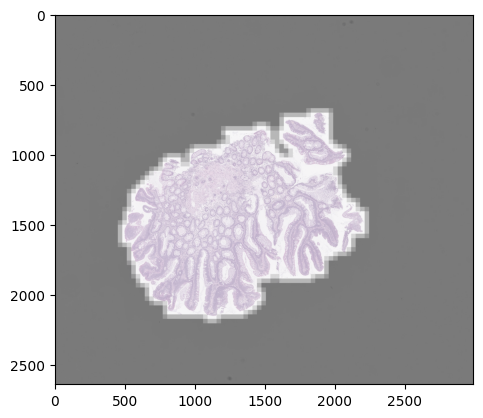

In [ ]:
with PSImage(p) as psim:
    heatmap = make_heatmap(psim, image.shape, mask, 0.0625, 256)
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5)
    plt.show()

In [ ]:
save_mask(heatmap, 'heat2.jpg')